In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.2.0
 GPU: /device:GPU:0


In [2]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'acc', 
                                             patience = 10, 
                                             restore_best_weights = True)

In [3]:
# Define dirs and files
train_dir = '../data/training/'
validation_dir = '../data/validation/'

train_wash_dir = os.path.join(train_dir,'wash')
train_nowash_dir = os.path.join(train_dir,'nowash')
validation_wash_dir = os.path.join(validation_dir,'wash')
validation_nowash_dir = os.path.join(validation_dir,'nowash')

print(len(os.listdir(train_wash_dir)))
print(len(os.listdir(train_nowash_dir)))
print(len(os.listdir(validation_wash_dir)))
print(len(os.listdir(validation_nowash_dir)))

total_train=len(os.listdir(train_wash_dir))+ len(os.listdir(train_nowash_dir))
total_val=len(os.listdir(validation_wash_dir))+ len(os.listdir(validation_nowash_dir))

144
167
37
42


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#  val data generator
val_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#set batch Size
batch_size = 10

#set Image size
imsize = (400,400) 
imshape = (400,400,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_directory( validation_dir,
                                                         batch_size = batch_size,
                                                         class_mode = 'binary',
                                                         target_size = imsize)


Found 311 images belonging to 2 classes.
Found 79 images belonging to 2 classes.


In [5]:
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [6]:
#base model, fully trainable but started w/ imagenet weights
base_model = tf.keras.applications.InceptionResNetV2(input_shape = imshape, 
                                                     include_top=False, 
                                                     weights='imagenet')

base_model.trainable = False
base_model.summary()


Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 199, 199, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 199, 199, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 199, 199, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

In [7]:
final_layer = base_model.get_layer('conv_7b_ac')
print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output


#add the last layer
# Flatten the output layer to 1 dimension
x = layers.Flatten()(final_base_output )
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)            

model = Model(base_model.input, x) 

model.summary()

shape of last layer is  (None, 11, 11, 1536)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 199, 199, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 199, 199, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 199, 199, 32) 0           batch_normalization[0][0]        
_________________________________________________

activation_38 (Activation)      (None, 47, 47, 32)   0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
activation_41 (Activation)      (None, 47, 47, 64)   0           batch_normalization_41[0][0]     
__________________________________________________________________________________________________
block35_5_mixed (Concatenate)   (None, 47, 47, 128)  0           activation_36[0][0]              
                                                                 activation_38[0][0]              
                                                                 activation_41[0][0]              
__________________________________________________________________________________________________
block35_5_conv (Conv2D)         (None, 47, 47, 320)  41280       block35_5_mixed[0][0]            
__________________________________________________________________________________________________
block35_5 

In [10]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics = acc_metric)

In [11]:
history = model.fit(train_generator,
                              steps_per_epoch = total_train // batch_size,
                              validation_data = validation_generator,
                              epochs= 100,
                              validation_steps =  total_val // batch_size,
                              callbacks =[callbacks])

Epoch 1/100
31/31 [==============================] - 77s 2s/step - loss: 4.8353 - acc: 0.7774 - val_loss: 2.9098 - val_acc: 0.7286
Epoch 2/100
31/31 [==============================] - 75s 2s/step - loss: 2.6540 - acc: 0.7608 - val_loss: 3.0051 - val_acc: 0.7286
Epoch 3/100
31/31 [==============================] - 76s 2s/step - loss: 1.4577 - acc: 0.8272 - val_loss: 1.3058 - val_acc: 0.8714
Epoch 4/100
31/31 [==============================] - 76s 2s/step - loss: 1.4303 - acc: 0.8106 - val_loss: 1.9734 - val_acc: 0.8571
Epoch 5/100
31/31 [==============================] - 77s 2s/step - loss: 1.4308 - acc: 0.8405 - val_loss: 1.1863 - val_acc: 0.8000
Epoch 6/100
31/31 [==============================] - 76s 2s/step - loss: 1.0926 - acc: 0.8704 - val_loss: 1.2851 - val_acc: 0.8714
Epoch 7/100
31/31 [==============================] - 74s 2s/step - loss: 1.1289 - acc: 0.8206 - val_loss: 1.8731 - val_acc: 0.8286
Epoch 8/100
31/31 [==============================] - 76s 2s/step - loss: 0.9299 - a

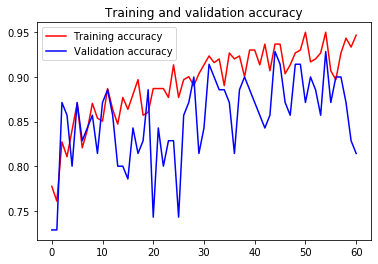

<Figure size 432x288 with 0 Axes>

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [13]:
#save the model
fp='./saved_InceptionResnet'
tf.keras.models.save_model(model,fp)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_InceptionResnet/assets


In [ ]:
'''
# load model

#model path
model_path = './saved_InceptionResnet'

#load it in to tf
model = tf.keras.models.load_model(model_path, compile = True)
'''

In [14]:
#test the model
import numpy as np

#define test directory
test_dir_wash = '../data/testing_michael/wash/'
test_dir_nowash = '../data/testing_michael/nowash'

#load images for wash
w_test = []
w_labels = []
for img in os.listdir(test_dir_wash):
    #pull the name of the image
    w_labels.append(img)
    #pull the image
    img = os.path.join(test_dir_wash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size=(400,400))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    w_test.append(img)

#load images for nowash
nw_test = []
nw_labels = []
for img in os.listdir(test_dir_nowash):
    #pull the name of the image
    nw_labels.append(img)
    #pull the image
    img = os.path.join(test_dir_nowash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size=(400,400))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    nw_test.append(img)

In [15]:
#make predictions 
w_test = np.vstack(w_test)
w_preds = model.predict(w_test)

nw_test = np.vstack(nw_test)
nw_preds = model.predict(nw_test)

In [16]:
#stack up the predicitons and truth in the same format

#vstack pred array
all_pred = np.vstack((nw_preds,w_preds))
all_pred = all_pred > 0.5

#vstack true array
all_true = np.vstack((np.full((70,1), False), np.full((70,1), True)))

In [17]:
#report relevant binary classification stats for test data
from sklearn import metrics

report = metrics.classification_report(all_true, all_pred)
print(report)

              precision    recall  f1-score   support

       False       0.75      0.86      0.80        70
        True       0.83      0.71      0.77        70

    accuracy                           0.79       140
   macro avg       0.79      0.79      0.78       140
weighted avg       0.79      0.79      0.78       140



In [18]:
#and the confusion matrix for test data
metrics.confusion_matrix(all_true, all_pred)

array([[60, 10],
       [20, 50]])

In [39]:
import pandas as pd 

#make labels into an array (nowash then wash)
nw_labels = np.vstack((np.asarray(nw_labels)))
w_labels = np.vstack((np.asarray(w_labels)))
all_labels = np.vstack((nw_labels, w_labels))

#make single df for image names, true class, and predicted class 
#data = np.hstack((all_labels, all_true, all_pred))
results_df = pd.DataFrame(np.hstack((all_labels, all_true, all_pred)), columns=["image", "Observed", "Predicted"])
results_df.head()

,image,Observed,Predicted
0,P28460485.jpg,False,False
1,P28460465.jpg,False,True
2,P28460374.jpg,False,True
3,P28468916.jpg,False,False
4,C28464815.jpg,False,False


In [40]:
#save the df as a csv
results_df.to_csv('../data/test_results/inception_resnet.csv', index=False)